In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns

from scipy import stats
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score



In [2]:
#Load in data as pandas DataFrames
pre_cancer = pd.read_csv("data\pre_cancer_markers.csv")
post_cancer = pd.read_csv("data\post_cancer_markers.csv")



#### Data cleaning

In [3]:
#Check for missing values (NaNs)
pre_nan = pre_cancer.isna().any(axis = None)
post_nan = post_cancer.isna().any(axis = None)
print(pre_nan, post_nan)

False False


#### Data visualisation
##### Distributions: 

interactive(children=(IntSlider(value=0, description='marker', max=5), Output()), _dom_classes=('widget-intera…

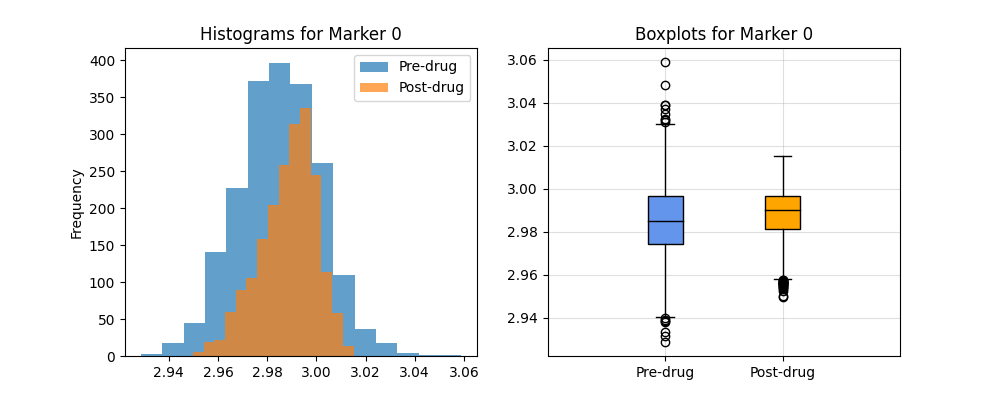

In [4]:

%matplotlib ipympl

fig, axes_h = plt.subplots(1, 2, figsize = (10, 4))

def update_distr(marker):
    """
    Displays the histograms and boxplots of the pre-drug and post-drug data of a given marker as part of an interactive widget.

    Args: 
        marker (int): One of the cancer markers between 0 and 5
    
    """
    for ax in axes_h:
        ax.clear()

    pre_marker = pre_cancer.iloc[:, marker]
    post_marker= post_cancer.iloc[:, marker]

    #Histograms of the pre- and post-drug marker data
    axes_h[0].hist(pre_marker, bins = 15, label = "Pre-drug", alpha = 0.7)
    axes_h[0].hist(post_marker, bins = 15, label = "Post-drug",alpha = 0.7)
    axes_h[0].legend()
    axes_h[0].set_ylabel("Frequency")
    axes_h[0].set_title(f"Histograms for Marker {marker}")

    #Boxplots of the pre- and post-drug marker data
    medianprops = dict(color='black')
    bplot = axes_h[1].boxplot( [pre_marker, post_marker], labels= ["Pre-drug", "Post-drug"] , patch_artist=True, positions=[1, 1.5],  medianprops = medianprops)

    bplot["boxes"][0].set_facecolor("cornflowerblue")
    bplot["boxes"][1].set_facecolor("orange")
    axes_h[1].set_title(f"Boxplots for Marker {marker}")
    axes_h[1].grid(alpha = 0.4)

    fig.canvas.draw()
    


widgets.interact(update_distr, marker =widgets.IntSlider(
    value=0,  max=5, step=1));

    



A note about the boxplots on the right: 

- The part of the data that appears boxed up is within the interquartile range (IQR: the difference between third and first quartile), and represent the spread of the middle 50\% of data. 
- The whiskers represent the spread of the data beyond the IQR up to about 1.5 times the lower/upper bounds. 
- Any data that falls beyond the whiskers are outliers and is plotted as dots.

The greater the size of the IQR and the whiskers, the larger the variability of the data.


##### Correlations

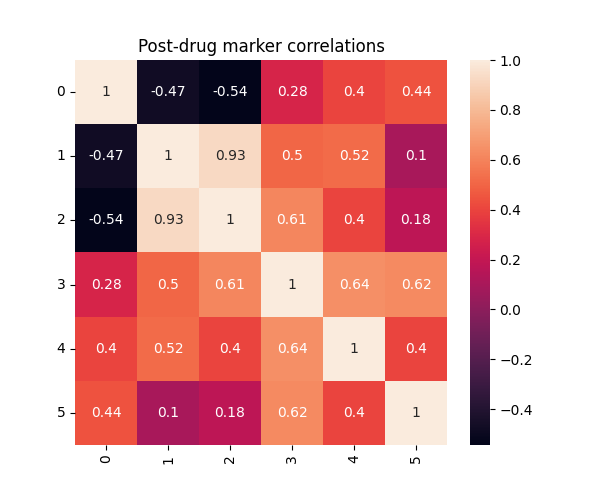

In [5]:

#Get the correlations of the post-drug markers
post_corr = post_cancer.corr()

#Plot the correlations as a 2D heatmap
fig, ax_c= plt.subplots( figsize = (6, 5))
sns.heatmap(post_corr, annot = True)

ax_c.set_xticklabels(np.arange(6))
ax_c.set_yticklabels(np.arange(6))

ax_c.set_title('Post-drug marker correlations')
plt.show()

#### PCA

In [6]:
#Print the variances of the unscaled post-drug markers to motivate the scaling
print("Unscaled variances:\n", post_cancer.var(axis = 0))

Unscaled variances:
 marker_0     0.000132
marker_1    24.608607
marker_2     6.419549
marker_3     0.000002
marker_4     0.000063
marker_5     0.000812
dtype: float64


In [7]:

# Scale the markers (both pre- and post-drug data) to have standard deviation of one and mean of zero
scaler = StandardScaler()
pre_cancer_scaled = scaler.fit_transform(pre_cancer)
post_cancer_scaled = scaler.fit_transform(post_cancer)

#create a joined dataset of scaled pre-and post-drug data to apply PCA on later as well
all_cancer = pd.concat([pre_cancer, post_cancer], axis = 0)
all_cancer_scaled = scaler.fit_transform(all_cancer)

In [8]:
def pca_analysis(data): 

    """
    Performs Principal Component Analysis on a dataset. 

    Args: 
        data (DataFrame or array): the dataset
    
    Returns: 
        var_ratios: The explained variance ratios of the principal components
        ex_var: The explained variance of the principal components
        scores: The PCA scores of the dataset
        loadings: The loadings of each principal component

    """

    pca = PCA()
    pca.fit(data)
    var_ratios= pca.explained_variance_ratio_
    ex_var = pca.explained_variance_
    loadings = pca.components_
    scores = pca.transform(data)

    return var_ratios, ex_var, scores, loadings

#Perform PCA on the scaled pre-drug, post-drug and combined pre-and post-drug datasets
var_ratios_pre, ex_var_pre, scores_pre, loadings_pre = pca_analysis(pre_cancer_scaled)
var_ratios_post, ex_var_post, scores_post, loadings_post = pca_analysis(post_cancer_scaled)
var_ratios_all, ex_var_all, scores_all, loadings_all = pca_analysis(all_cancer_scaled)



##### How many Principal Components to use?

interactive(children=(Dropdown(description='Dataset', options=('Post-drug', 'Pre-drug', 'Both Pre-and Post-dru…

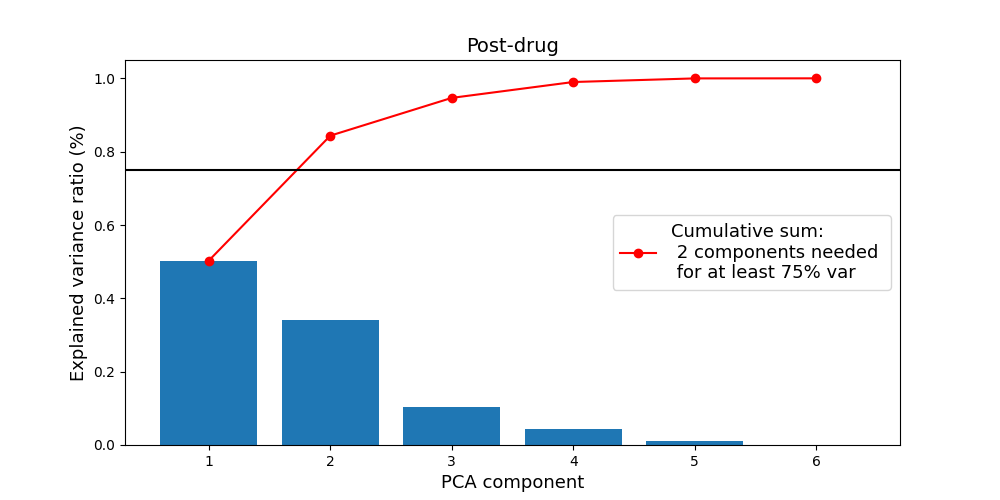

In [9]:

var_thresh = 0.75 #The threshold for the desired total percent explained variance

fig, ax_v = plt.subplots( figsize = (10, 5))

def switch_var_data(Dataset):

    """
    Used in a widget to display a plot of the explained variance ratio and the cumulative sum against the principal components as a function of which dataset the PCA was done on. 

    Args: 
        Dataset (string): Either "Pre-drug", "Post-drug", or "Both Pre-and Post-drug". Used to plot the corresponding variance ratios for that dataset.
    
    """

    #Choose the correct explained variance ratios to plot
    if Dataset == "Pre-drug":
        ratios = var_ratios_pre

    elif Dataset == "Post-drug":
        ratios = var_ratios_post

    elif Dataset == "Both Pre-and Post-drug":
        ratios = var_ratios_all

    #Get the cumulative sum of the ratios
    cumsum = np.cumsum(ratios)

    #the x-axis for the plot which shows the principal components
    x = np.arange(1, len(var_ratios_pre)+1)
    
    # print ("Explained variance ratios: ", [np.round(r, 4) for r in ratios])
    # print ("Cumulative sum of the explained variance ratios: ", [np.round(s, 4) for s in cumsum])

    ax_v.clear()

    #Plot both the explained variance ratios as a barplot and the cumulative sum as a line
    ax_v.bar(x, ratios)
    ax_v.plot(x,cumsum, marker = "o", label = f"Cumulative sum: \n {np.where(cumsum >= var_thresh)[0][0] + 1} components needed \n for at least {int(var_thresh*100)}% var", c = "r" )
    ax_v.axhline(var_thresh, c = "black")

    ax_v.set_ylabel("Explained variance ratio (%)", fontsize = 13)
    ax_v.set_xlabel("PCA component", fontsize = 13)
    ax_v.set_title(Dataset, fontsize = 14)
    ax_v.legend(fontsize = 13)
    
    fig.canvas.draw()


widgets.interact(switch_var_data, Dataset =[ "Post-drug", "Pre-drug", "Both Pre-and Post-drug"]);


##### PCA scores and Loadings analysis

interactive(children=(Checkbox(value=False, description='Plot (magnified) marker vectors'), Output()), _dom_cl…

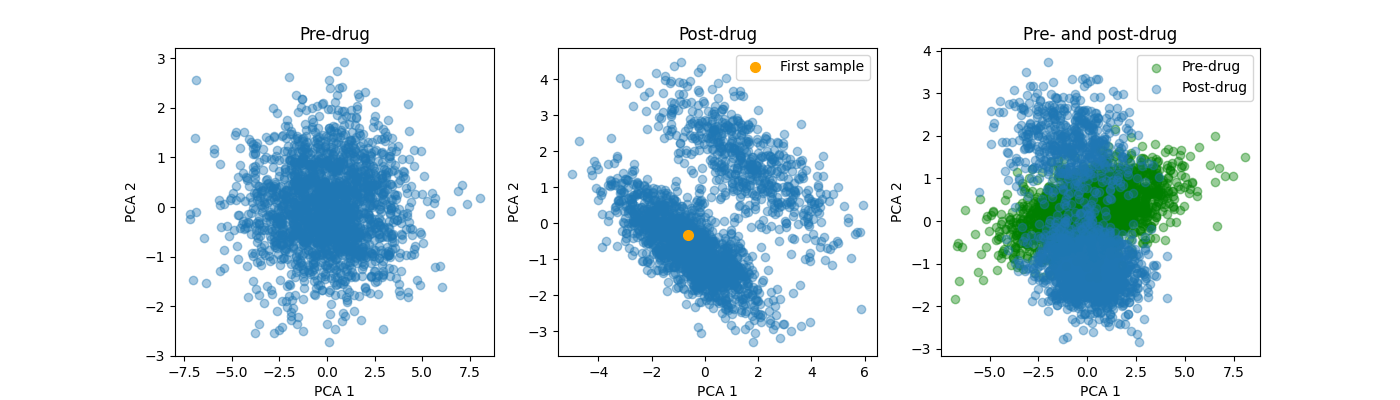

In [10]:

fig_p, axes_p = plt.subplots(1, 3, figsize = (14, 4))

def plot_pca(plt_vectors):
    """
    Plots the projections of the datasets (pre-drug, post-drug and combined) onto the space defined by the first two principal components as scatter plots. Or, in other words, the PC2 scores against the PC1 scores. 
    Args: 
        plt_vectors (bool): Plots the loadings of the markers as vectors in the PC component space if True, and hides them if False.
    
    """

    for ax in axes_p:
        ax.clear()

    #Which principal components to plot against eachother
    i, j = 0, 1

    alpha = 0.4

    #Plots the projections of the pre-drug onto the PC1-PC2 space
    axes_p[0].scatter(scores_pre[:, i], scores_pre[:, j], alpha = alpha)

    #Plots the projections of the post-drug onto the PC1-PC2 space, with the first sample marked. 
    axes_p[1].scatter(scores_post[:, i], scores_post[:, j],alpha = alpha)
    axes_p[1].plot(scores_post[0, i], scores_post[0, j], marker = "o", linestyle = "None", markersize = 7, color = "orange", label = "First sample")
    axes_p[1].legend()

    #Plots the projections of the combined pre- and post-drug onto the PC1-PC2 space.
    axes_p[2].scatter(scores_all[:len(pre_cancer), i], scores_all[:len(pre_cancer), j], alpha =alpha, label = "Pre-drug", c = "g")
    axes_p[2].scatter(scores_all[len(pre_cancer):, i], scores_all[len(pre_cancer):, j], alpha = alpha, label = "Post-drug")
    axes_p[2].legend()

    #Function to plot the principal component 1 and 2 loadings for each marker as (magnified) vectors, with labels
    def plot_vectors(ax, loadings, horiz_align):
        for m in range(6):
            ax.arrow(0, 0, loadings[i, m]*3.5, loadings[j, m]*3.5, color="r", head_width=0.25)
            ax.text(loadings[i, m]*4.5, loadings[j, m]*4.5, f"{m}", color='black', fontsize = 15, ha = horiz_align)

    if plt_vectors == True:
        plot_vectors(axes_p[0], loadings_pre, "right")
        plot_vectors(axes_p[1], loadings_post, "left")
        plot_vectors(axes_p[2], loadings_all, "right")


    axes_p[0].set_title("Pre-drug")
    axes_p[1].set_title("Post-drug")
    axes_p[2].set_title("Pre- and post-drug")


    for ax in axes_p:
        ax.set_xlabel(f"PCA {i + 1}")
        ax.set_ylabel(f"PCA {j + 1}")
        
    fig_p.canvas.draw()
    
widgets.interact(plot_pca, plt_vectors =widgets.Checkbox(value=False, description='Plot (magnified) marker vectors'));


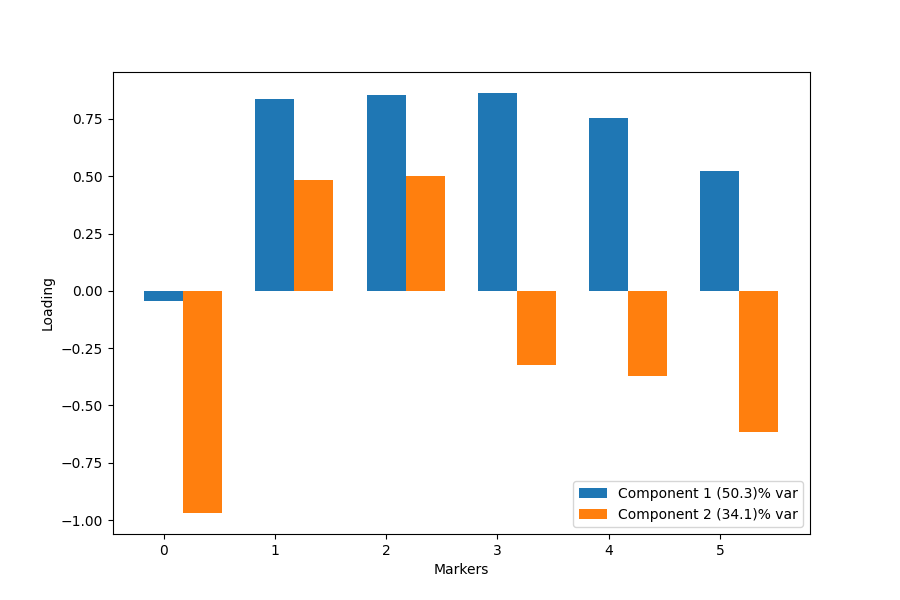

In [11]:

#Plots the PC1 and PC2 loadings for each marker as barplots, for the Post-drug data
fig_l, ax_l = plt.subplots(figsize = (9, 6))

width = 0.35 #width of the bars
ind = np.arange(len(loadings_post))  

ax_l.bar(ind, loadings_post[0, :]*np.sqrt(ex_var_post[0]), width, label = f"Component 1 ({var_ratios_post[0]*100:.1f})% var")
ax_l.bar(ind+width, loadings_post[1, :]*np.sqrt(ex_var_post[1]), width, label = f"Component 2 ({var_ratios_post[1]*100:.1f})% var")
ax_l.set_xlabel("Markers")
ax_l.set_ylabel("Loading")

ax_l.legend()
#plt.savefig("C:/Users/nicol/OneDrive - University of Bristol/IntermComp/loadings")

plt.show()



#### Post-drug cluster analysis



 71.55% of patients presented reduced cancer symptoms after being treated with the drug.


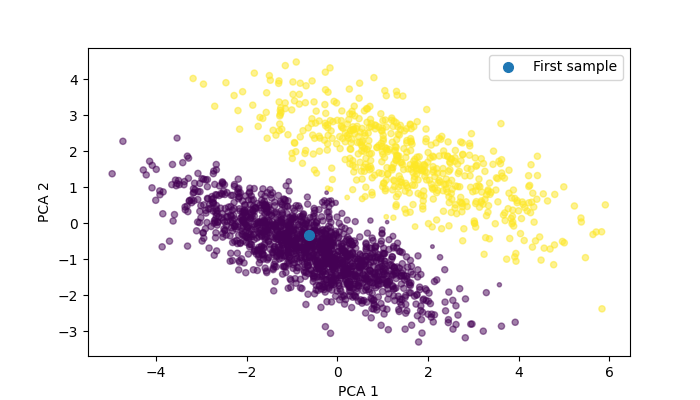

In [12]:
#Retrieve the score data for the first two principal components (post-drug)
post_scores_12pca = scores_post[:, :2]
n_clusters = 2

#Apply the Gaussian Mixture Model , and retrieve the cluster labels of each sample as well as their probabilities
gmm = GaussianMixture(n_components=n_clusters).fit(post_scores_12pca)
labels = gmm.predict(post_scores_12pca)
probs = gmm.predict_proba(post_scores_12pca)

#size of the plotted samples as a function of their probability of belonging to that cluster
size = 20 * probs.max(axis=1) ** 2

#Get the number of samples in each cluster
s1 = len(np.where(labels == 0)[0])
cluster_sizes = s1, len(labels) - s1

#Find out which cluster the first sample (improved symptoms) belongs to and what its cluster size is to determine the % of people with imporved symptoms
first_sample_label = labels[0]
first_sample_cluster_size = cluster_sizes[first_sample_label]
print(f" {first_sample_cluster_size/len(labels)*100:.2f}% of patients presented reduced cancer symptoms after being treated with the drug.")


#Retrieve the indices of the samples for each cluster for later analysis
improv_sample_inds = np.where(labels == first_sample_label)[0]
noimprov_sample_inds = np.where(labels == 1-first_sample_label)[0]

#plot the PCA scatter plot with the samples assigned to their clusters
fig, ax_g = plt.subplots(figsize=(7, 4))
ax_g.plot(scores_post[0, 0], scores_post[0,1 ], marker = "o", linestyle = "None", markersize = 7, label = "First sample")
ax_g.scatter(post_scores_12pca[:, 0], post_scores_12pca[:, 1], c = labels, s = size, alpha = 0.5)
ax_g.set_xlabel("PCA 1")
ax_g.set_ylabel("PCA 2")
ax_g.legend()

plt.show()


##### Improved and not improved symptoms groups' distributions

interactive(children=(IntSlider(value=0, description='marker', max=5), Output()), _dom_classes=('widget-intera…

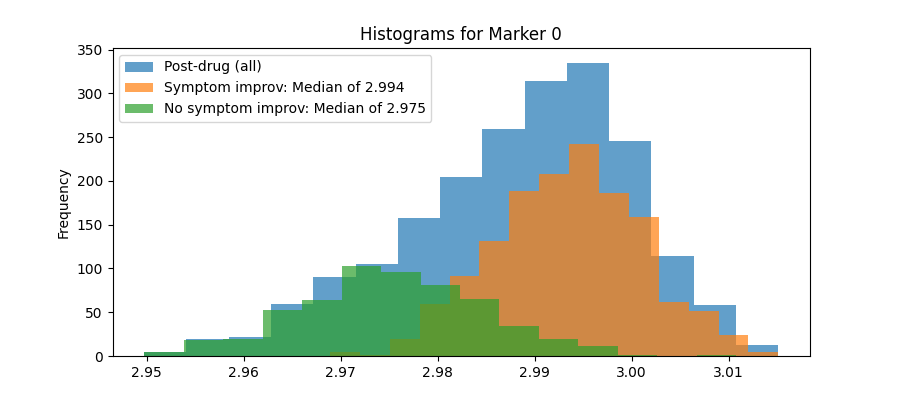

In [13]:

fig, axes_n = plt.subplots( figsize = (9, 4))

def update(marker):
    """
    Plots the post-drug distributions and the distributions for the "improved symptoms" and "not improved symptoms" groups for each marker.

    Args: 
        marker (int): Marker from 0 to 5 
    """
   
    axes_n.clear()
    
    def get_data_hists(ax, data, marker):
    
        #Get the marker values for each group
        marker_noimprov= data.iloc[noimprov_sample_inds, marker]
        marker_improv= data.iloc[improv_sample_inds, marker]
        marker_data= data.iloc[:, marker]
            
        ax.hist(marker_data, bins = 15,alpha = 0.7, label = "Post-drug (all)")
        ax.hist(marker_improv, bins = 15,alpha = 0.7, label = f"Symptom improv: Median of {marker_improv.median():.3f}")
        ax.hist(marker_noimprov, bins = 15,alpha = 0.7, label = f"No symptom improv: Median of {marker_noimprov.median():.3f}")

        ax.legend()
        ax.set_ylabel("Frequency")
       

    get_data_hists(axes_n, post_cancer, marker)

    axes_n.set_title(f"Histograms for Marker {marker}")
    
    fig.canvas.draw()


widgets.interact(update, marker =widgets.IntSlider(
    value=0,  max=5, step=1));




#### Mann-Whitney U test


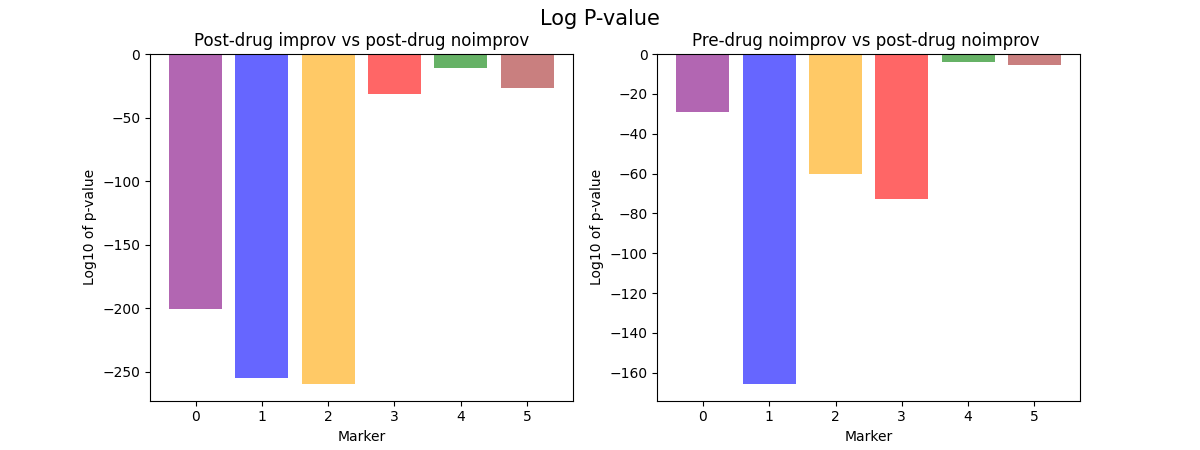

In [14]:


def mann_whit_markers(data1, data2):
    """
    Performs the Mann-Whitney U significance test on two given data groups for each marker. 

    Args: 
        data1, data2 (DataFrames): the two datasets to be compared
    
    Returns: 
        The p-values for each marker.
    """

    marker_range = data1.shape[1]
    mann_whit_pvals = np.zeros(marker_range)

    for marker in range(marker_range):
        marker_grp1 = data1.iloc[:, marker]
        marker_grp2 = data2.iloc[:, marker]
        mann_whit_res = stats.mannwhitneyu(marker_grp1, marker_grp2) 
        mann_whit_pvals[marker] = mann_whit_res[1]

    return mann_whit_pvals

#Get the p-values for each marker form comparing following groups post drug imorved vs not imporved, and post-drug not improved vs pre-drug not improved.
pvals_post_improvs = mann_whit_markers(post_cancer.iloc[noimprov_sample_inds, :], post_cancer.iloc[improv_sample_inds, :])
pvals_pre_post_noimprov = mann_whit_markers(post_cancer.iloc[noimprov_sample_inds, :], pre_cancer.iloc[noimprov_sample_inds, :])

#Take the log of the p-values
log_pvals_post_improvs = np.log10(pvals_post_improvs)
log_pvals_pre_post_noimprov = np.log10(pvals_pre_post_noimprov)

#Plot the p-values of each marker for each of the pairs as three barplots
fig, axes = plt.subplots(1, 2,  figsize = (12, 4.5))
colors = ["purple", "blue", "orange", "red", "green", "brown"]

for ax, pvals in zip(axes, [ log_pvals_post_improvs, log_pvals_pre_post_noimprov]): 
    ax.bar(np.arange(6), pvals, color = colors, alpha = 0.6)
    ax.set_ylabel("Log10 of p-value")
    ax.set_xlabel("Marker")


axes[0].set_title("Post-drug improv vs post-drug noimprov")
axes[1].set_title("Pre-drug noimprov vs post-drug noimprov ")
fig.suptitle("Log P-value", fontsize = 15)
plt.show()




